In [60]:
# NB. Run this in Google colab NOT Jupyter lab.  https://colab.research.google.com/notebooks/intro.ipynb?utm_source=scs-index#recent=true
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [61]:
# Import libraries
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [62]:
sf_df = pd.read_csv('zillow_bedroom3_CA_3yr.csv',index_col=0)

In [63]:
# Make sure to set the zip codes down the rows
sf_df

,4/30/2018,5/31/2018,6/30/2018,7/31/2018,8/31/2018,9/30/2018,10/31/2018,11/30/2018,12/31/2018,1/31/2019,2/28/2019,3/31/2019,4/30/2019,5/31/2019,6/30/2019,7/31/2019,8/31/2019,9/30/2019,10/31/2019,11/30/2019,12/31/2019,1/31/2020,2/29/2020,3/31/2020,4/30/2020,5/31/2020,6/30/2020,7/31/2020,8/31/2020,9/30/2020,10/31/2020,11/30/2020,12/31/2020,1/31/2021,2/28/2021,3/31/2021,4/30/2021
Zip,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
94109,2130062,2131772,2135398,2139172,2139358,2130341,2134219,2134635,2130438,2144300,2154963,2163355,2153972,2158369,2168078,2166787,2158038,2151150,2160568,2169202,2182998,2180265,2184426,2173069,2164827,2144387,2125586,2118364,2115953,2114618,2094918,2077283,2058643,2045047,2025833.0,2015766.0,2010121
90250,637867,641904,645149,648845,650768,652322,654350,656754,657787,658057,655964,654376,654724,659269,664799,666600,666931,667107,668811,671153,676863,683360,690762,697138,702236,704001,704895,710043,717811,726563,734725,742269,748281,754554,762051.0,770630.0,780450
94565,392917,396119,400856,409441,413240,418477,421064,423545,423693,421847,420788,419370,419810,421232,422359,421912,420045,418675,420082,423965,427659,428772,429495,432760,435766,435831,435292,435959,440377,443844,446910,447582,450126,455255,461604.0,466804.0,472311
90046,1760877,1755089,1749264,1743263,1741232,1737003,1741506,1748692,1751007,1749466,1740172,1734127,1734441,1746624,1756632,1743672,1730411,1724719,1740202,1749452,1759038,1762758,1775206,1787169,1798453,1804152,1811637,1839589,1866046,1887115,1888088,1891790,1898806,1912399,1923580.0,1933774.0,1943551
94501,1115313,1125495,1130851,1124806,1121445,1112080,1114016,1111794,1104156,1092689,1085696,1089607,1097451,1110845,1122726,1136498,1137035,1138896,1133375,1131725,1140375,1159703,1170607,1173932,1167793,1162050,1156972,1158776,1170960,1185568,1202986,1220271,1233379,1241969,1258359.0,1279471.0,1309172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96061,164161,163357,167332,173144,175435,175222,174212,173614,174211,173725,172350,173860,180430,185170,184101,179120,177139,175266,177098,178151,179726,181576,182965,180988,175401,170884,171041,172415,173207,175204,174313,173828,172530,171691,171934.0,173847.0,176713
95141,1549016,1554726,1585995,1612896,1606926,1569308,1549706,1535600,1530033,1512214,1497636,1471459,1440469,1433246,1422915,1449687,1457629,1467044,1461778,1460032,1479644,1487025,1503856,1532086,1559189,1559894,1544224,1516036,1518160,1532945,1549706,1563216,1557214,1566024,1565155.0,1562574.0,1567172
95375,379047,379571,380384,377313,370428,364516,363329,363124,361476,362687,365135,368640,369855,364140,357016,349639,354366,359951,365114,364875,365615,365970,364843,362573,359499,360196,361678,365555,363283,360785,358423,359845,361620,363875,367284.0,371691.0,377706


# New Section

In [64]:
# set the random seed
np.random.seed(42)
#remove text column headers
data = sf_df.values
data_scaled = data/1000000

Scale the data


In [65]:
# Scale the data so that the model doesn't take too long to run (and to remove all units to ensure all features are on the same footing)
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(data)
# scaler.transform(data)
# data_scaled = scaler.transform(data)

In [66]:
# data_scaled.shape

Define training/testing/validation cells

In [67]:
train_stop = 1100
valid_stop = 1300
n_steps = len(sf_df.columns)
n_steps

37

In [68]:
# split the data into test, training and validation sets
X_train, y_train = data_scaled[:train_stop,:-1], data_scaled[:train_stop,-1]
X_valid, y_valid = data_scaled[train_stop:valid_stop,:-1], data_scaled[train_stop:valid_stop,-1]
X_test, y_test =   data_scaled[valid_stop:,:-1], data_scaled[valid_stop:,-1]

In [69]:
y_train = np.expand_dims(y_train,-1)
y_valid = np.expand_dims(y_valid,-1)
y_test = np.expand_dims(y_test,-1)
X_train = np.expand_dims(X_train,-1)
X_valid = np.expand_dims(X_valid,-1)
X_test = np.expand_dims(X_test,-1)

In [70]:
# Define a function to plot our sample
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, 0, 1])


In [71]:
X_valid[0,:,0].shape

(36,)

Saving figure time_series_plot


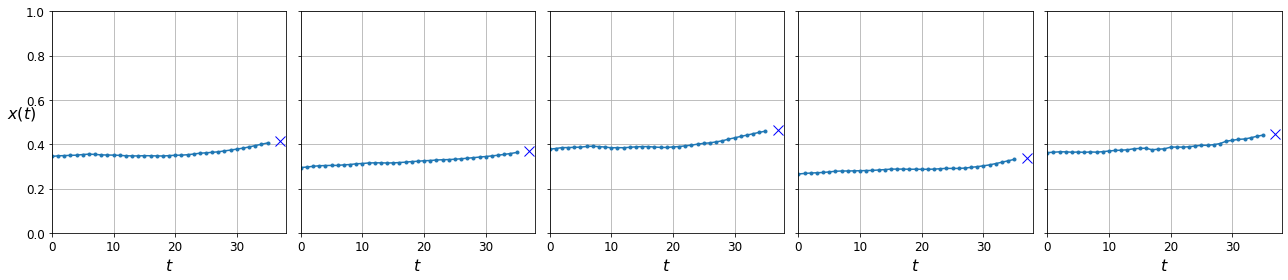

In [72]:
fig, axes = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=(18, 4))
for col in range(5):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()
# 'x' in the graphs is what we are trying to predict

Establish a baseline

In [73]:
#Assume the base prediction is simply the last datapoint in the series
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))
# The number below is the MSE of the last datapoint. 

0.00012415521710500005

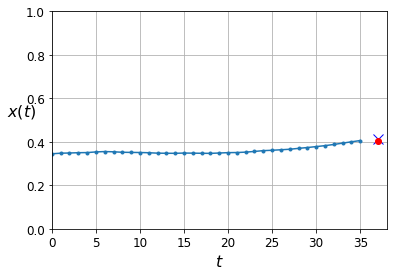

In [74]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [75]:
np.random.seed(42)
tf.random.set_seed(42)

In [76]:
# simple linear regression
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[36, 1]),
    keras.layers.Dense(1)
])


In [77]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 36)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 37        
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [78]:
model.compile(loss="mse", optimizer="adam")
model.evaluate(X_valid, y_valid)
# The MSE for the simple linear model is about 0.195. Higher than that of the machine learning model.

7/7 [==============================] - 0s 2ms/step - loss: 0.7711


0.7711336612701416

In [79]:
# This is the simplest model we can build (simple Recurrant neural network (RNN)). Contains a single layer with a single neuron. 
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=6,
                    validation_data=(X_valid, y_valid))

Epoch 1/6
35/35 [==============================] - 0s 5ms/step - loss: 0.6189 - val_loss: 0.0312
Epoch 2/6
35/35 [==============================] - 0s 2ms/step - loss: 0.0111 - val_loss: 0.0021
Epoch 3/6
35/35 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 4/6
35/35 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 5/6
35/35 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 6/6
35/35 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0017


In [80]:
# Deep RNN
model = keras.models.Sequential([
  keras.layers.LSTM(128, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(1)
    #This gives us 2 hidden layers and 1 layer at the end (the final number!. return_sequences=true ensures it passes the entire time series along at each layer)
])

In [81]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, None, 128)         66560     
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
lstm_5 (LSTM)                (None, 1)                 520       
Total params: 198,664
Trainable params: 198,664
Non-trainable params: 0
_________________________________________________________________


In [82]:
# We tried up to 20 epochs but the model started to exhibit signs of overfitting (training loss < validation loss) so we decided to stop at 6.
model.compile(loss=tf.keras.losses.mean_squared_error, optimizer="adam")
history = model.fit(X_train, y_train, epochs=6,
                    validation_data=(X_valid, y_valid))

Epoch 1/6
35/35 [==============================] - 4s 34ms/step - loss: 0.2737 - val_loss: 0.0856
Epoch 2/6
35/35 [==============================] - 0s 11ms/step - loss: 0.1960 - val_loss: 0.0835
Epoch 3/6
35/35 [==============================] - 0s 10ms/step - loss: 0.1944 - val_loss: 0.0830
Epoch 4/6
35/35 [==============================] - 0s 10ms/step - loss: 0.1941 - val_loss: 0.0830
Epoch 5/6
35/35 [==============================] - 0s 11ms/step - loss: 0.1941 - val_loss: 0.0830
Epoch 6/6
35/35 [==============================] - 0s 10ms/step - loss: 0.1941 - val_loss: 0.0829


In [83]:
model.evaluate(X_valid, y_valid)
# we want our loss function to be as close to 0 as possible.
# The MSE below is about 0.08. A lot better than that of the simple linear regression model.

7/7 [==============================] - 0s 4ms/step - loss: 0.0829


0.08292609453201294

In [84]:
model.save("bedroom3_trained.hdf5")

In [85]:
X_train[:,1:,:].shape

(1100, 35, 1)

In [86]:
y_train[:,].shape

(1100, 1)

In [87]:
# Model evaluations
model.evaluate(X_train,y_train)

35/35 [==============================] - 0s 5ms/step - loss: 0.1940


0.19401656091213226

In [88]:
model.evaluate(X_valid,y_valid)

7/7 [==============================] - 0s 5ms/step - loss: 0.0829


0.08292609453201294

In [89]:
model.evaluate(X_test,y_test)

12/12 [==============================] - 0s 5ms/step - loss: 0.0634


0.06344316899776459

In [90]:
# X_train: Use expand_dims in order to give the y_train an extra dimension.
x_train_pred = np.concatenate((X_train[:,1:,:],np.expand_dims(y_train,-1)),axis=1)

In [91]:
# build y_train prediction
y_train_pred = model.predict(x_train_pred)
y_train_pred.shape

(1100, 1)

In [92]:
# X_valid: Use expand_dims in order to give the y_train an extra dimension.
x_valid_pred = np.concatenate((X_valid[:,1:,:],np.expand_dims(y_valid,-1)),axis=1)

In [93]:
# build y_valid prediction
y_valid_pred = model.predict(x_valid_pred)
y_valid_pred.shape

(200, 1)

In [94]:
# X_test: Use expand_dims in order to give the y_train an extra dimension.
x_test_pred = np.concatenate((X_test[:,1:,:],np.expand_dims(y_test,-1)),axis=1)

In [95]:
# build y_test prediction
y_test_pred = model.predict(x_test_pred)
y_test_pred.shape

(372, 1)

In [97]:

# concatenate all three y_pred series together and append them to the original data
y_pred_all = np.concatenate((y_train_pred,y_valid_pred,y_test_pred),axis=0)
y_pred_all_df = pd.DataFrame(y_pred_all).astype('float')
y_pred_all_df*1000000

# np.mean(scaler.inverse_transform(np.concatenate((y_pred_all,np.zeros((1714,303))),axis=1))[:,0])

,0
0,999892.711639
1,792393.088341
2,490199.327469
3,999889.373779
4,999799.847603
...,...
1667,190054.684877
1668,999879.956245
1669,397790.074348
1670,290306.955576


In [102]:
sf_df['5/31/2021'] = y_pred_all_df[0].values

In [103]:
sf_df["max"]=sf_df.iloc[:,0:-2].max(axis=1)

In [104]:
sf_df["min"]=sf_df.iloc[:,0:-3].min(axis=1)


In [105]:
sf_df['5/31/2021_scaled'] = sf_df['5/31/2021']*(sf_df['max']-sf_df['min'])+sf_df['min']

In [106]:
sf_final_df = sf_df.drop(['max','min','5/31/2021'],axis=1)

In [107]:
sf_final_df.rename(columns={'5/31/2021_scaled':'5/31/2021'},inplace=True)
sf_final_df

,4/30/2018,5/31/2018,6/30/2018,7/31/2018,8/31/2018,9/30/2018,10/31/2018,11/30/2018,12/31/2018,1/31/2019,2/28/2019,3/31/2019,4/30/2019,5/31/2019,6/30/2019,7/31/2019,8/31/2019,9/30/2019,10/31/2019,11/30/2019,12/31/2019,1/31/2020,2/29/2020,3/31/2020,4/30/2020,5/31/2020,6/30/2020,7/31/2020,8/31/2020,9/30/2020,10/31/2020,11/30/2020,12/31/2020,1/31/2021,2/28/2021,3/31/2021,4/30/2021,5/31/2021
Zip,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
94109,2130062,2131772,2135398,2139172,2139358,2130341,2134219,2134635,2130438,2144300,2154963,2163355,2153972,2158369,2168078,2166787,2158038,2151150,2160568,2169202,2182998,2180265,2184426,2173069,2164827,2144387,2125586,2118364,2115953,2114618,2094918,2077283,2058643,2045047,2025833.0,2015766.0,2010121,2.184192e+06
90250,637867,641904,645149,648845,650768,652322,654350,656754,657787,658057,655964,654376,654724,659269,664799,666600,666931,667107,668811,671153,676863,683360,690762,697138,702236,704001,704895,710043,717811,726563,734725,742269,748281,754554,762051.0,770630.0,780450,6.184234e+05
94565,392917,396119,400856,409441,413240,418477,421064,423545,423693,421847,420788,419370,419810,421232,422359,421912,420045,418675,420082,423965,427659,428772,429495,432760,435766,435831,435292,435959,440377,443844,446910,447582,450126,455255,461604.0,466804.0,472311,2.315268e+05
90046,1760877,1755089,1749264,1743263,1741232,1737003,1741506,1748692,1751007,1749466,1740172,1734127,1734441,1746624,1756632,1743672,1730411,1724719,1740202,1749452,1759038,1762758,1775206,1787169,1798453,1804152,1811637,1839589,1866046,1887115,1888088,1891790,1898806,1912399,1923580.0,1933774.0,1943551,1.943336e+06
94501,1115313,1125495,1130851,1124806,1121445,1112080,1114016,1111794,1104156,1092689,1085696,1089607,1097451,1110845,1122726,1136498,1137035,1138896,1133375,1131725,1140375,1159703,1170607,1173932,1167793,1162050,1156972,1158776,1170960,1185568,1202986,1220271,1233379,1241969,1258359.0,1279471.0,1309172,1.308910e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96061,164161,163357,167332,173144,175435,175222,174212,173614,174211,173725,172350,173860,180430,185170,184101,179120,177139,175266,177098,178151,179726,181576,182965,180988,175401,170884,171041,172415,173207,175204,174313,173828,172530,171691,171934.0,173847.0,176713,3.519258e+04
95141,1549016,1554726,1585995,1612896,1606926,1569308,1549706,1535600,1530033,1512214,1497636,1471459,1440469,1433246,1422915,1449687,1457629,1467044,1461778,1460032,1479644,1487025,1503856,1532086,1559189,1559894,1544224,1516036,1518160,1532945,1549706,1563216,1557214,1566024,1565155.0,1562574.0,1567172,1.612702e+06
95375,379047,379571,380384,377313,370428,364516,363329,363124,361476,362687,365135,368640,369855,364140,357016,349639,354366,359951,365114,364875,365615,365970,364843,362573,359499,360196,361678,365555,363283,360785,358423,359845,361620,363875,367284.0,371691.0,377706,1.513132e+05


In [108]:
sf_final_df.to_csv('bedroom3_final_predicted_3yr.csv',index=True)